In [114]:
# Code to look at wavelength errors vs. no wavelengths in a small period (delta lambda)
# Should be able to compare to theoretical bounds for a single source.
import jax.numpy as np
import dLux as dl
import dLuxToliman as dlT
import dLux.utils as dlu
import matplotlib.pyplot as plt
import jax
import jax.random as jr
from scipy.special import jv
import zodiax as zdx
import optax
from tqdm import tqdm
from scipy.stats import binned_statistic

In [115]:
# gonna get some weighted binning:
def weighted_binning(x, y, x_centers):
    x = np.asarray(x)
    y = np.asarray(y)
    x_centers = np.asarray(x_centers)

    bin_values = np.zeros_like(x_centers, dtype=float)

    for xi, yi in zip(x, y):
        # Find the indices of the two closest x_centers
        idx = np.searchsorted(x_centers, xi)
        
        if idx == 0:
            # xi is left of all centers
            #bin_values[0] += yi
            bin_values = bin_values.at[0].add(yi)
        elif idx == len(x_centers):
            # xi is right of all centers
            #bin_values[-1] += yi
            bin_values = bin_values.at[-1].add(yi)
        else:
            x_left = x_centers[idx - 1]
            x_right = x_centers[idx]
            d_left = abs(xi - x_left)
            d_right = abs(x_right - xi)
            total_dist = d_left + d_right
            if total_dist == 0:
                # Exactly on a bin center
                #bin_values[idx - 1] += yi
                bin_values = bin_values.at[idx - 1].add(yi)
            else:
                # Split proportionally
                #bin_values[idx - 1] += yi * (d_right / total_dist)
                bin_values = bin_values.at[idx - 1].add(yi * (d_right / total_dist))
                #bin_values[idx]     += yi * (d_left  / total_dist)
                bin_values = bin_values.at[idx].add(yi * (d_left / total_dist))

    return bin_values


In [116]:
# constructing the telescope:
wf_npixels = 128 # 128 lowest power of 2 necessary
diameter = 0.125 #
period = 304e-6 
difference = np.pi * 0.348

apertureLayer = dlT.TolimanApertureLayer(wf_npixels)

layers = [
    (
        'aperture',
        apertureLayer
    )
]

psf_npixels = 64
psf_pixel_scale = 0.375
oversample = 4 # 4 seems good

optics = dl.AngularOpticalSystem(wf_npixels,diameter,layers,psf_npixels,psf_pixel_scale,oversample)

In [163]:
# creating the source
# wavelength stuff (meters)
start_lambda = 580e-9
stop_lambda = 590e-9
# seems... sus. I reckon just do raw number wavelengths then calculate delta lambda
# n_lambda = 21, totally tractable
# = 31, middle gets really muddy
# = 26, middle slightly better but not perfect
# = 23 again very close but not exactly perfect
# 22 is baically perfect

n_lambda = 101
wavelengths = np.linspace(start_lambda, stop_lambda, n_lambda)
delta_lambda = wavelengths[1]-wavelengths[0]

key = 2
weights = jr.uniform(jr.PRNGKey(key), n_lambda)

n_lambda_model = 21
wavelengths_model = np.linspace(start_lambda, stop_lambda, n_lambda_model)

# bin the weights and make them into 21
weights_new = weighted_binning(wavelengths, weights, wavelengths_model)

weights_norm = weights/np.sum(weights)

weights_new_norm = weights_new/np.sum(weights_new)

flux = 5*1000000000
flux_renorm = flux/(jv(0, difference/4)**2 * jv(1, difference/4)**2)

source = dl.PointSource(wavelengths, flux=flux_renorm, weights=weights_norm)

print(wavelengths_model)
source_model = dl.PointSource(wavelengths_model, flux=flux_renorm, weights = np.ones(n_lambda_model)/n_lambda_model)

telescope = dl.Telescope(optics, source)
telescope_model = dl.Telescope(optics, source_model)

sidelobescope = dlT.SideLobeTelescope(telescope, period, difference)
sidelobescope_model = dlT.SideLobeTelescope(telescope_model, period, difference)

center_wl = 585e-9

sidelobe_raw = sidelobescope.model_sidelobes(center_wavelength = center_wl, downsample = oversample)

sidelobe_poisson = jr.poisson(jr.PRNGKey(key), sidelobe_raw)

print(delta_lambda)

[5.8000001e-07 5.8050000e-07 5.8099999e-07 5.8150005e-07 5.8200004e-07
 5.8249998e-07 5.8299997e-07 5.8349997e-07 5.8400002e-07 5.8450001e-07
 5.8500001e-07 5.8550000e-07 5.8600000e-07 5.8649999e-07 5.8699999e-07
 5.8749998e-07 5.8799998e-07 5.8850003e-07 5.8900002e-07 5.8949996e-07
 5.9000001e-07]
Model time: 1.7644 seconds.
9.9987574e-11


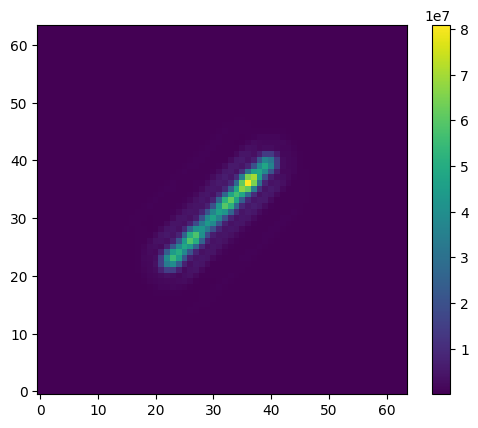

In [164]:
plt.imshow(sidelobe_poisson, origin='lower')
plt.colorbar()
plt.show()

In [165]:
weights_path = 'telescope.source.spectrum.weights'

parameters = [weights_path]

# initial guess for weights, uniform ones!
#model = sidelobescope.set(weights_path, np.ones(n_lambda)/n_lambda)
# new oversampled model
model = sidelobescope_model

# Optimisation
# 10% initial learning rate.
weights_optimiser = optax.adam(0.1/n_lambda)

optimisers = [weights_optimiser]

optim, opt_state = zdx.get_optimiser(model, parameters, optimisers)

In [166]:
@zdx.filter_jit
@zdx.filter_value_and_grad(parameters)
def loss_fn(model, data):
    out = model.model_sidelobes(center_wavelength = center_wl, downsample = oversample)
    #return np.sum((data-out)**2)
    return -np.sum(jax.scipy.stats.poisson.logpmf(data, out))

In [167]:
losses, models_out = [], []
n_iter = 2000
with tqdm(range(n_iter),desc='Gradient Descent') as t:
    for i in t: 
        loss, grads = loss_fn(model, sidelobe_poisson)

        updates, opt_state = optim.update(grads, opt_state)

        # # prevent negative weights
        # # Get current weights
        weights = model.get(weights_path)

        # # Get update for weights
        weight_updates = updates.get(weights_path)

        # define epsilon
        epsilon = 1e-6
        safe_updates = np.where(weights + weight_updates < epsilon, epsilon-weights, weight_updates)

        # Create a copy of updates and replace the weights update with safe update
        updates = updates.set(weights_path, safe_updates)

        model = zdx.apply_updates(model, updates)
        losses.append(loss)
        models_out.append(model)
        t.set_description("Log Loss: {:.3f}".format(np.log10(loss))) # update the progress bar

Gradient Descent:   0%|          | 0/2000 [00:00<?, ?it/s]

Model time: 0.3333 seconds.


Log Loss: 5.590: 100%|██████████| 2000/2000 [00:59<00:00, 33.80it/s]


In [30]:
weights_residuals = np.array([

        (models_out[it].telescope.source.spectrum.weights / np.sum(models_out[it].telescope.source.spectrum.weights)
        - weights_new_norm)
    
    for it in np.arange(n_iter)
])

In [45]:
from scipy.ndimage import gaussian_filter1d

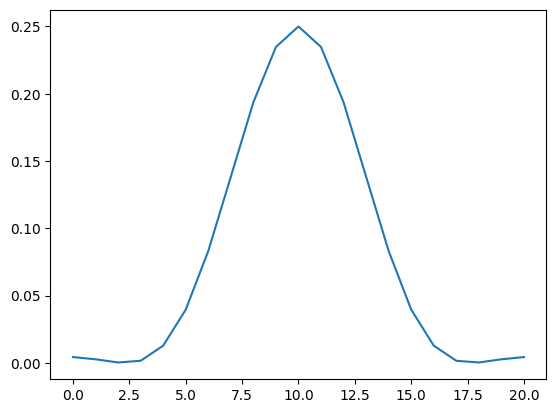

[0.00429232 0.00263649 0.00027261 0.00154062 0.01277344 0.03953641
 0.08315288 0.13835251 0.19364451 0.23477602 0.25       0.23477602
 0.19364451 0.1383525  0.08315288 0.03953641 0.01277344 0.00154062
 0.00027261 0.00263649 0.00429232]


In [87]:
domain = np.linspace(-5,5,21)

bessel_conv = jv(1, domain)**2/domain**2

bessel_conv = np.nan_to_num(bessel_conv, nan=0.25)
plt.plot(bessel_conv)
plt.show()
print(bessel_conv)

In [168]:
final_weights_2 = models_out[-1].weights
final_weights_norm_2 = final_weights_2/np.sum(final_weights_2)

In [153]:
import matplotlib.patheffects as pe
text_path_effects=[pe.Stroke(linewidth=1, foreground='k'), pe.Normal()]
path_effects = [pe.Stroke(linewidth=5, foreground='k'), pe.Normal()]

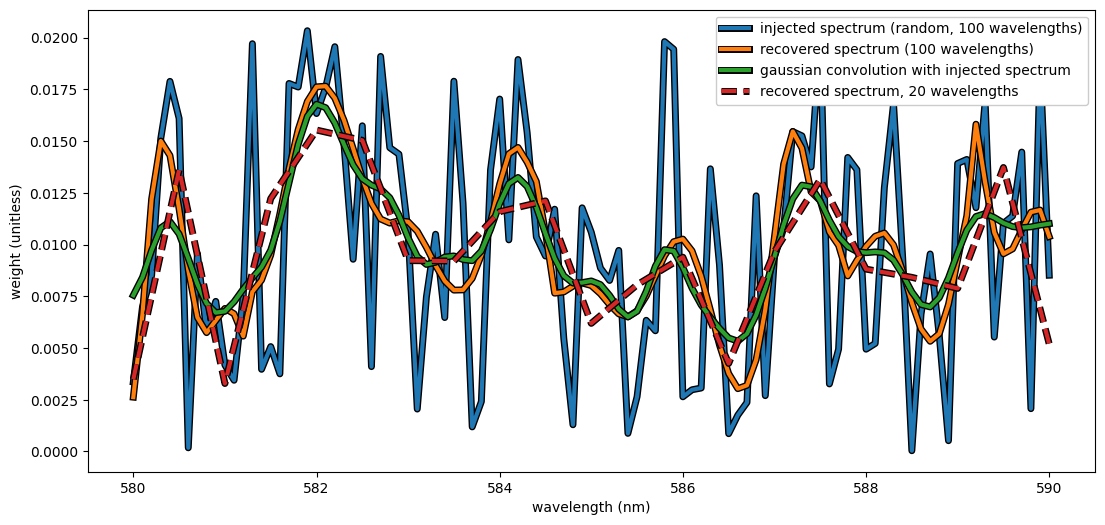

In [173]:
plt.figure(figsize=(13,6))
plt.plot(wavelengths*10**9, weights_norm, path_effects = path_effects,linewidth=3, 
         label='injected spectrum (random, 100 wavelengths)')
plt.plot(wavelengths*10**9, final_weights_norm, path_effects = path_effects,linewidth=3,
         label='recovered spectrum (100 wavelengths)')

#plt.plot(wavelengths_model, weights_new_norm)
convolved_weights = np.convolve(weights_norm, bessel_conv, mode='same')
gaus_weights = gaussian_filter1d(weights_norm, 2.2)
#plt.plot(wavelengths, 0.7*convolved_weights)
plt.plot(wavelengths*10**9, gaus_weights, path_effects = path_effects,linewidth=3,
         label='gaussian convolution with injected spectrum')
plt.xlabel('wavelength (nm)')
plt.ylabel('weight (unitless)')
plt.plot(wavelengths_model*10**9, final_weights_norm_2/5, path_effects = path_effects,linewidth=3,
         label='recovered spectrum, 20 wavelengths', linestyle='--')
plt.legend(framealpha=1)
plt.savefig('example_spectrum_2.pdf', transparent=False, bbox_inches='tight')
plt.savefig('example_spectrum_2.png', dpi=300, transparent=False, bbox_inches='tight')
plt.show()

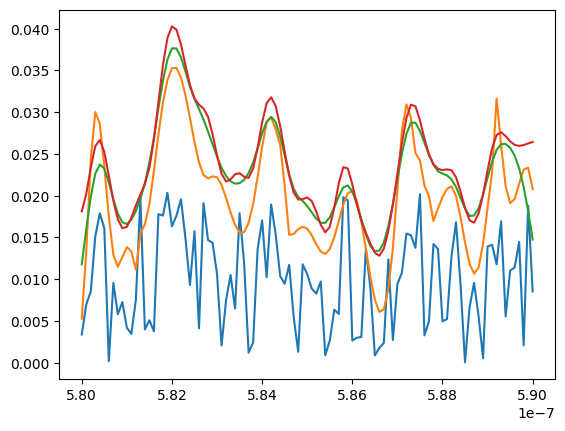

In [130]:
final_weights = models_out[-1].weights
final_weights_norm = final_weights/np.sum(final_weights)

plt.plot(wavelengths, weights_norm)
plt.plot(wavelengths_model, 2*final_weights_norm)
#plt.plot(wavelengths_model, weights_new_norm)
convolved_weights = np.convolve(weights_norm, bessel_conv, mode='same')
gaus_weights = gaussian_filter1d(weights_norm, 2.2)
plt.plot(wavelengths, 1.4*convolved_weights)
plt.plot(wavelengths, 2.4*gaus_weights)
plt.show()

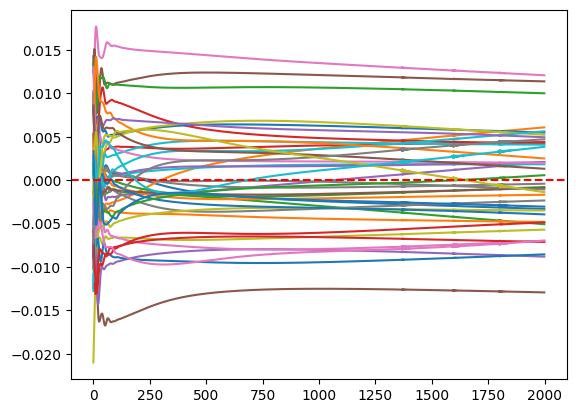

In [33]:
plt.plot(weights_residuals)
plt.axhline(0, linestyle='--', color='red')
# plt.ylim(-0.001,0.001)
plt.show()

Model time: 1.6401 seconds.


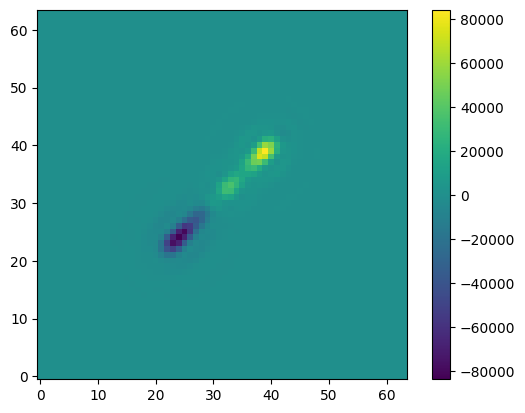

3855273.0


In [131]:
res_psf = models_out[-1].model_sidelobes(center_wl, downsample=oversample)-sidelobe_raw
plt.imshow(res_psf,origin='lower')
# plt.xlim(24,40)
# plt.ylim(24,40)
plt.colorbar()
plt.show()
print(np.sum(np.abs(res_psf)))

In [ ]:
# 31 modelling 41: 724482.56
# 41 modelling 41: 708407.1
# 41 modelling 101:? 694022.56
# 101 modelling 101: 3855273.0 (but this was 5 billion photons, others 1 billion)

# 41 modelling 101 raw?: 676808.1
# 41 modelling 41 raw?: 673340.5
# 21 modelling 41 raw?: 9640351.0 (a LOT)
# 21 modelling 101 raw?: 2944614.5
# 101 modelling 101 raw?: 401234.62 (quite low)
# it gives a really nice smooth spectrum back though!